# Introduction
This modules introduces two new objects to scqubits - `SymbolicCircuit` and `Circuit`, which will allow the user to analyze a custom defined circuit. The module `SymbolicCircuit` finds all the periodic and extended degrees of freedom, eliminates the non-dynamical cyclic and frozen modes and then evaluates the symbolic Hamiltonian in terms of the transformed variables. The `Circuit` object then works on the data generated by `SymbolicCircuit` to perform the numerical diagonalization depending on various options set by the user. It can perform numerical diagonalization in discretized phi or harmonic oscillator basis and also utilize the method of hierarchical diagonalization depending on the subsystem identification defined by the user allowing access to numerical analysis of larger circuits. 

# Basics

## Defining a circuit as an input
Any generalized circuit consisting of junctions (along with junction capacitance), inductors and capacitors can be defined in the form of an input string. For example, here is the circuit of zero-pi where all the nodes are labled.


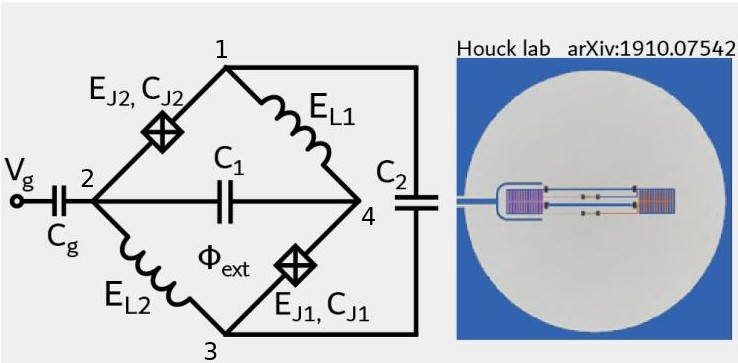

This graph of this circuit can be represented using the following YAML format file:
```
#zero-pi.yaml
nodes    : 4
# zero-pi
branches:
- [JJ, 1,2, EJ = 10, 20]
- [JJ, 3,4, 10, 20]
- [L, 2,3, 0.008]
- [L, 4,1, 0.008]
- [C, 1,3, 0.02]
- [C, 2,4, 0.02]
```
The above string can be saved as a YAML file or a string which can be used to initiate a Circuit object. This example also elucidates all the different rules to be followed when defining an input file:
- The first line begins with `nodes: 4` which defines the number of nodes in the circuit
  minus the ground node. If a ground node present, it should be represented by the index
  zero. For example a capacitor connected to the ground can be represented as `C,	0,
  1,	2`, which indicates a capacitor which is connected between the nodes ground and
  node-1 with a capacitance energy of 2GHz.
- The next line is `branches:` which demarcates the portion of the file where branches are defined.  
- Each branch is represented using the following syntax `- [<branch-type>, <node-1>, <node-2>, <param-1>, <param-2>]`.
	- Branch type can be the following: `C`, `L` or `JJ`.
	- The branch type `C` and `L` have one branch parameter while `JJ` has two branch parameters - junction energy and capacitance.
	- comma is used as a delimiter in one line, so the connected nodes should not be separated by a space after the comma. 
	- The branch parameters can be float, intergers or a symbol which can be used for
	parameter sweeps. When a symbol is used for the first time in the circuit description, it needs
	to be initialized with a default value. For instance, in the above example the
	junction energies of both the junctions are varied with the symbol `EJ`, which is
	only initialized once.
    - Any lines starting with `#` will be ignored and thus can be used for commenting.

# Initializing and working with `Circuit` object
Using the input file from the above circuit, we can then define a circuit object in the following way.

In [45]:
input_string = """#zero-pi.yaml
nodes    : 4
# zero-pi
branches:
- [JJ, 1,2, EJ = 10, 20]
- [JJ, 3,4, 10, 20]
- [L, 2,3, 0.008]
- [L, 4,1, 0.008]
- [C, 1,3, 0.02]
- [C, 2,4, 0.02]
"""

In [46]:
import scqubits as scq
zero_pi = scq.Circuit.from_yaml(input_string, is_file=False, ext_basis="discretized")

The above command initializes the computation of symbolic Hamiltonian, which can be viewed using the attribute `hamiltonian_symbolic`. These modules use `Sympy` for dealing with any general expressions. The module `SymbolicCircuit` also evaluates all the external flux and the offset charge variables present in the circuit. The attribute `ext_basis` can take two kinds of input `"discretized"` or `"harmonic"` which lets the user to choose whether to use discretized phi or harmonic oscillator basis for the extended degrees of freedom in the circuit.

In [47]:
zero_pi.hamiltonian_symbolic.expand()

-EJ*cos(1.0*θ1 - 1.0*θ3) + 0.01*Q2**2 + 40.0000000000023*Q3**2 + 1.13684175848237e-15*Q3*n1 + 1.13684175848237e-15*Q3*ng_1 + 0.03996003996004*n1**2 + 0.0799200799200799*n1*ng_1 + 0.03996003996004*ng_1**2 + 0.032*θ2**2 + 0.008*θ3**2 - 10.0*cos(-Φ1 + 1.0*θ1 + 1.0*θ3)

In the above hamiltonian expression, all the variables are represented with $\theta_i$ and the conjugate charge with $Q_i$ if the variable is extended or $n_i$ if the variable is periodic. All the cyclic and frozen variables are already eliminated to get to this final symbolic Hamiltonian. The symbolic Lagrangian in terms of the node variables and the new variables can also be accessed using `lagrangian_symbolic` and `lagrangian_node_vars`.

In [48]:
zero_pi.lagrangian_node_vars

EJ*cos(φ1 - φ2) + 0.5*vφ1*(6.25625*vφ1 - 0.00625*vφ2 - 6.25*vφ3) + 0.5*vφ2*(-0.00625*vφ1 + 6.25625*vφ2 - 6.25*vφ4) + 0.5*vφ3*(-6.25*vφ1 + 6.25625*vφ3 - 0.00625*vφ4) + 0.5*vφ4*(-6.25*vφ2 - 0.00625*vφ3 + 6.25625*vφ4) - 0.004*(φ1 - φ4)**2 - 0.004*(-φ2 + φ3)**2 + 10.0*cos(Φ1 - φ3 + φ4)

In [49]:
zero_pi.lagrangian_symbolic

EJ*cos(1.0*θ1 - 1.0*θ3) + 6.25625*vθ1**2 + 25.0*vθ2**2 + 0.00624999999999964*vθ3**2 - 5.33427468862868e-16*vθ3*vθ4 - 1.77809156287623e-16*vθ4**2 - 0.032*θ2**2 - 0.008*θ3**2 + 10.0*cos(-Φ1 + 1.0*θ1 + 1.0*θ3)

Further, the types of variables identified in the circuit can be viewed using
`var_categories` attribute.

In [50]:
zero_pi.var_categories

{'periodic': [1], 'extended': [2, 3], 'cyclic': [], 'frozen': []}

The transformation matrix which transforms the new variables defined using $\theta_i$ to node variables defined using $\varphi_i$ can be viewed using the attribute `trans_mat`.

In [51]:
zero_pi.transformation_matrix

array([[ 0., -1.,  1.,  1.],
       [ 1., -1.,  0.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 0.,  1.,  0.,  1.]])

Each of the variable index has its corresponding cutoff defined as an attribute. The list of these attributes can be accessed using:

In [52]:
zero_pi.cutoff_names

['cutoff_n_1', 'cutoff_ext_2', 'cutoff_ext_3']

At this point, all we need to do is to define the cutoffs and call `zero_pi.eigenvals()` to get the eigen energies of the Hamiltonian. 

In [53]:
zero_pi.cutoff_n_1 = 5
zero_pi.cutoff_phi_2 = 10
zero_pi.cutoff_phi_3 = 10
zero_pi.eigenvals()

array([-3.66713832, -3.65542458, -3.64979332, -3.63807958, -3.54945453,
       -3.54891778])

These eigen values, in this case, are not converged and we need to increase the cutoffs to a large value for convergence. But, this can be expensive for a circuit like zero-pi. Thus, let us try to use hierarchical diagonalization. Looking at the expression generated above from the attribute `hamiltonian_symbolic`, we can see that the variable $\theta_2$ corresponds to the zeta oscillator in zero-pi. Thus, we can pair the variables $1$ and $3$ to a single subsystem. This can be done in the following way. First, define an object which identifies different different subsystems by grouping of the variables. In this object note that, every subsystem is enclosed in `[...]`.

In [54]:
system_hierarchy = [[1,3], [2]]

The above object indicates that we would want to pair the indices $1, 3$ into a single subsystem and the variable index $2$ into a separate subsystem. Do note that this can be done recursively. For example, a zero pi qubit can be paired with another oscillator with variable index $4$ using `[[[1,3], [2]], [4]]`. Each subsystem needs to be enclosed in square brackets even if it contains a single variable index. This object can then be given to a method `truncation_template` which generates the object for defining the default truncated dimensions for each of the sybsystems.

In [55]:
from scqubits.core.circuit import truncation_template
truncation_template(system_hierarchy)

[6, 6]

This object returned has the default truncated dimensions for each of the subsystem indexed in the same order as in `system_hierarchy`. This default truncated dims can now be changed accordingly and given as a parameter along with `system_hierarchy` to the method `update_system_hierarchy`.

In [56]:
zero_pi.set_system_hierarchy(system_hierarchy=system_hierarchy, subsystem_trunc_dims=[150, 80])

The object `zero_pi` now initiates subsystems accordingly, whose symbolic hamiltonians and interactions can be viewed using the attribute `subsystems_sym` which refers to the symbolic expressions of the Hamiltonian and the interactions with other subsystems. For example, the hamiltonian of the zero'th subsystem can be accessed using

In [57]:
zero_pi.subsystem_hamiltonians[0]

-EJ*θc1*cos(1.0*θ3) - EJ*θs1*sin(1.0*θ3) + 0.03996003996004*I**2*ng_1**2 + 1.13684175848237e-15*I*Q3*ng_1 + 0.0799200799200799*I*n1*ng_1 + 1.13684175848237e-15*Q3*n1 + 40.0000000000023*Qs3 + 0.03996003996004*n1**2 + 0.008*θ3**2 - 10.0*θc1*sin(1.0*θ3)*sin(6.28318530717959*I*Φ1) - 10.0*θc1*cos(1.0*θ3)*cos(6.28318530717959*I*Φ1) + 10.0*θs1*sin(1.0*θ3)*cos(6.28318530717959*I*Φ1) - 10.0*θs1*sin(6.28318530717959*I*Φ1)*cos(1.0*θ3)

while its interaction can be accessed using

In [58]:
zero_pi.subsystem_interactions[0]

0

Each of the subsystems are also created as an instance of the class `Circuit`. Thus, each subsystem can access all the features as described above. To find the eigenvalues of the subsystem for example: 

In [59]:
zero_pi.subsystems[0].eigenvals()

array([-3.68734689, -3.67563315, -2.78296393, -2.76247374, -2.66402511,
       -2.6544701 ])

Since we are using hierarchical diagonalization we can use higher cutoffs.

In [60]:
zero_pi.cutoff_n_1 = 10
zero_pi.cutoff_ext_2 = 100
zero_pi.cutoff_ext_3 = 80

All the external flux variables and offset charges can also be set by setting the attributes. To look at the variables for the circuit at hand call: 

In [61]:
zero_pi.external_fluxes

[Φ1]

In [62]:
zero_pi.offset_charges

[ng_1]

In [63]:
zero_pi.Φ1 = 0.5
zero_pi.ng_1 = 0.6

Now the eigenvalues and the parameter sweeps can be calculated like any other qubit in scqubits.

In [20]:
eigs = zero_pi.eigenvals()
eigs - eigs[0]

array([0.00000000e+00, 1.74686492e-06, 3.57534715e-02, 3.57552184e-02,
       7.14405625e-02, 7.14423094e-02])

Spectral data:   0%|          | 0/21 [00:00<?, ?it/s]

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Φ1', ylabel='energy [GHz]'>)

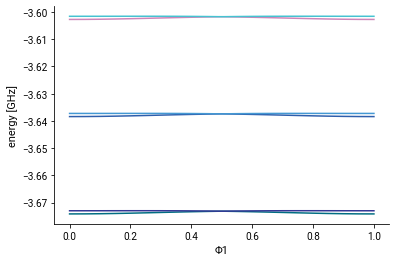

In [24]:
import numpy as np
zero_pi.plot_evals_vs_paramvals("Φ1", np.linspace(0,1,21))

# Plotting the potential
Potential of the circuit can also be plotted using the method `plot_potential`. To see how the potential expression looks like, we can call the attribute `potential_symbolic`.

In [21]:
zero_pi.potential_symbolic

-EJ*cos(1.0*θ1 - 1.0*θ3) + 0.016*(-θ2 + 0.5*θ3)**2 + 0.016*(θ2 + 0.5*θ3)**2 - 10.0*cos(-Φ1 + 1.0*θ1 + 1.0*θ3)

There are three degrees of freedoms in this potential for which ranges need to be specified. The variables like external flux can also be specified, else they are fetched from the Circuit attributes. Do note that only a maximum of two ranges can be specified as we can only plot in 3D. The method returns a line plot when only one range is specified.

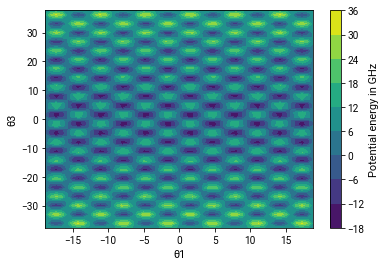

In [22]:
import numpy as np
zero_pi.plot_potential(θ1=np.linspace(-6*np.pi, 6*np.pi), θ3=np.linspace(-12*np.pi, 12*np.pi), θ2 = 0)

# Plotting the wavefunction
`plot_wavefunction` method is used to plot the wavefunction. It takes two arguments, which specify the choice of the wavefunction to be plotted and the variable indices along which it needs to be plotted. Again, a maximum of two variable indices can be requested to make a plot.

TypeError: Shapes of x (80, 100) and z (100, 80) do not match

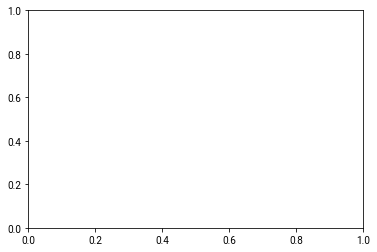

In [64]:
zero_pi.plot_wavefunction(n=0, var_indices=(2,3))

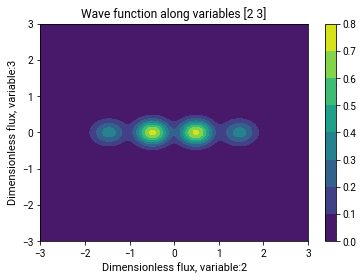

In [44]:
zero_pi.plot_wavefunction(n=0, var_indices=(2,3))

# Extra features implemented in this module

In many cases, it might be possible that the transformation generated by the code is not what the user prefers. In such an instance the user can define a transformation and provide it as an input to the `initiate_circuit` method. The same applies to the external flux variables and to which branches they get associated to. The user can provide the list of branches to which external flux can be associated to (Do note that any limit has not been implemented in the code to allow the user to associate external flux to more than one branch in a superconducting loop; though in this case the user must make sure the external flux assignment is consistent with what is expected from the circuit as the result might not be physical in some cases). In the case of zero-pi for example user can define custom transformation and closure branches as follows:

In [35]:
import scqubits as scq
from scqubits.core.circuit import truncation_template
import numpy as np

zero_pi = scq.Circuit.from_yaml(input_string, is_file=False, ext_basis="harmonic", basis_completion="simple")

In [36]:
zero_pi.hamiltonian_symbolic.expand()

-EJ*cos(1.0*θ1 - 1.0*θ3) + 0.01*Q2**2 + 40.0000000000023*Q3**2 + 1.13684175848237e-15*Q3*n1 + 1.13684175848237e-15*Q3*ng_1 + 0.03996003996004*n1**2 + 0.0799200799200799*n1*ng_1 + 0.03996003996004*ng_1**2 + 0.032*θ2**2 + 0.008*θ3**2 - 10.0*cos(-Φ1 + 1.0*θ1 + 1.0*θ3)

In [37]:
zero_pi.branches

[Branch(JJ, 1, 2),
 Branch(JJ, 3, 4),
 Branch(L, 2, 3),
 Branch(L, 4, 1),
 Branch(C, 1, 3),
 Branch(C, 2, 4)]

In [38]:
closure_branches = [zero_pi.branches[3]]

trans_mat = np.array([[ -1,  -1,  1,  1],
                       [ 1,  1,  1,  1],
                       [ 1,  -1, -1,  1],
                       [ -1,  1,  -1,  1]])*0.5
system_hierarchy = [[1,2],[3]]
truncation_template(system_hierarchy)

[6, 6]

In [39]:
zero_pi.initiate_circuit(transformation_matrix=trans_mat, system_hierarchy=system_hierarchy, subsystem_trunc_dims=[50, 100], closure_branches=closure_branches)

In [40]:
zero_pi.hamiltonian_symbolic.expand()

-EJ*cos(1.0*θ1 + 1.0*θ2) + 40.000000000002*Q2**2 - 2.8449465006021e-16*Q2*Q3 + 2.8421043962059e-16*Q2*n1 + 2.8421043962059e-16*Q2*ng_1 + 0.04*Q3**2 + 0.03996003996004*n1**2 + 0.0799200799200799*n1*ng_1 + 0.03996003996004*ng_1**2 + 0.004*Φ1**2 - 0.008*Φ1*θ2 + 0.008*Φ1*θ3 + 0.008*θ2**2 + 0.008*θ3**2 - 10.0*cos(1.0*θ1 - 1.0*θ2)

In [42]:
zero_pi.Φ1 = 0.0
zero_pi.ng_1 = 0.0

zero_pi.cutoff_n_1 = 6
zero_pi.cutoff_ext_2 = 80
zero_pi.cutoff_ext_3 = 100
eigs = zero_pi.eigenvals()
eigs - eigs[0]

array([0.        , 0.03577709, 0.07155418, 0.10733126, 0.14310835,
       0.17888544])

# Tips when dealing with large circuits

- When the circuit size is larger than a 4 nodes, it is better to not use many symbols for capacitances in the input file as the symbolic matrix conversion required for symbolic Hamiltonian can be expensive. This functionality will be improved in the future when the symbolic Hamiltonian will only be computed after all the parameters are substiuted.
- The methods `from_input_string` and `from_input_file` also take `basis_completion` as a parameter which can take two strings: `"simple"` and `"standard"`. These represent the two methods in which the identity matrix is generated to complete the transformation matrix to transform the node variables to new variables $\theta_i$. `"standard"` refers to an Identity, while `"simple"` refers to a matrix generated using itertools where each column has more than one non zero entries. Depending on the scenario, one of the above two options can result in a simpler Hamiltonian, resulting in a significant improvement in diagonalization time.